# Homework 4
Kazimierz Wojciechowski
16.04.2020

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
import lime
import lime.lime_tabular

In [54]:

file = "mushrooms.csv"
df = pd.read_csv(file)

## Edibility label encoding scheme
* 1 indicates edibility
* 0 stands for toxicity

In [55]:
labels = [(1.0 if cls == 'p' else 0.0) for cls in df['class']] 
df_wo_class = df.drop(['class'], axis=1)

In [56]:
def variable_encode(value):
    return ord(value)

def variable_decode(value):
    return chr(value)

In [57]:
df_wo_class_numeric = df_wo_class.copy()
for col in df_wo_class.columns:
    for k in range(len(df_wo_class[col])):
        df_wo_class_numeric[col][k] = variable_encode(df_wo_class[col][k])

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
    train_test_split(df_wo_class_numeric, labels, test_size = 0.3, random_state = 314159265)

## Task 1
> For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=9,
    max_depth=3
    )
rf_model.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

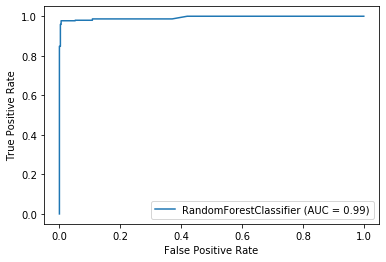

In [63]:
roc_value = plot_roc_curve(rf_model, test_features, test_labels)
plt.show()

Area under the curve is large, 99% just for 9 estimators with a maximum depth of 3 nodes.

## Task 2
> For some selected observation from this dataset, calculate the model predictions for model (1)

In [64]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [65]:
def rf_predict(id):
    random_forest_prediction = rf_model.predict(test_features.iloc[id : id+1])[0]
    labels = ['edible', 'poisonous']
    edibility_class = int(np.round(random_forest_prediction))
    print(f'Random forest prediction result: {random_forest_prediction} (on a scale from 0. to 1.)')
    print(f'The mushroom is predicted to be {color.BOLD}{labels[edibility_class]}{color.END}, in reality it is {color.BOLD}{labels[int(test_labels[id])]}{color.END}.')

In [87]:
rf_predict(4)

Random forest prediction result: 0.0 (on a scale from 0. to 1.)
The mushroom is predicted to be edible, in reality it is edible.


## Task 3
> For an observation selected in (2), calculate the decomposition of model prediction using Ceteris paribus / ICE profiles (packages for R: DALEX, ALEPlot, ingredients, packages for python: pyCeterisParibus).

In [197]:
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.explainer import explain
from ceteris_paribus.plots.plots import plot

rf_explainer = explain(rf_model, data=test_features, y=test_labels, label='RandomForest',
    predict_function=lambda X: rf_model.predict_proba(X)[::, 1])

def cp_plot(mushroom_id, columns, explainer):
    mushroom = test_features.iloc[mushroom_id : mushroom_id+1]
    label_mushroom = int(test_labels[mushroom_id])
    cp = individual_variable_profile(explainer, mushroom, label_mushroom)
    plot(cp, selected_variables=columns)

def cp_plots(mushroom_id, columns, explainer1, explainer2):
    mushroom = test_features.iloc[mushroom_id : mushroom_id+1]
    label_mushroom = int(test_labels[mushroom_id])
    cp1 = individual_variable_profile(explainer1, mushroom, label_mushroom)
    cp2 = individual_variable_profile(explainer2, mushroom, label_mushroom)
    plot(cp1, cp2, selected_variables=columns)

In [180]:
columns = list(df_wo_class_numeric.columns)

In [181]:
cp_plot(4, ['odor'], rf_explainer)

### Ceteris Paribus decomposition of mushroom #4 from the test set
![](./hw4_assets/3_gill-color.png)
![](./hw4_assets/3_gill-size.png)
![](./hw4_assets/3_habitat.png)
![](./hw4_assets/3_odor.png)
![](./hw4_assets/3_ring-number.png)
![](./hw4_assets/3_spore-print-color.png)
![](./hw4_assets/3_stalk-color-below-ring.png)
![](./hw4_assets/3_stalk-surface-above-ring.png)

Decompositions of remaining variables are practically constant functions.

## Task 4
> Find two observations in the data set, such that they have different CP profiles (e.g. model response is growing with age for one observations and lowering with age for another). Note that you need to have model with interactions to have such differences

In [199]:
for i in range(20):
    cp_plot(900+i, ['habitat'], rf_explainer)

gill-size: 100-120
spore-print-color: 100-120

In [166]:
print(variable_decode(112))
print(variable_decode(117))
print(variable_decode(119))

p
u
w


In [173]:
df_wo_class_numeric.groupby(['habitat']).describe()

cap-shape                   cap-surface                   cap-color  \
            count unique  top  freq       count unique  top  freq     count   
habitat                                                                       
100          3148      4  120  1558        3148      3  121  1472      3148   
103          2148      4  120  1008        2148      3  115   882      2148   
108           832      5  107   260         832      4  115   480       832   
109           292      3   98   146         292      2  121   146       292   
112          1144      4  120   474        1144      3  121   620      1144   
117           368      3  120   168         368      3  115   208       368   
119           192      3  120    64         192      2  121    96       192   

                ... ring-type       spore-print-color                    \
        unique  ...       top  freq             count unique  top  freq   
habitat         ...                                                       
100          9  ...       112  2024              3148      5  110  1008   
103          6  ...       112   948              2148      5  110   624   
108          5  ...       101   632               832      5  119   640   
109          4  ...       112   292               292      3  110   128   
112          6  ...       101   576              1144      4  119   616   
117          4  ...       112   368               368      3  104   144   
119          4  ...       101   192               192      1  119   192   

        population                    
             count unique  top  freq  
habitat                               
100           3148      4  118  1904  
103           2148      5  115   840  
108            832      2  118   720  
109            292      3  115   128  
112           1144      3  118   808  
117            368      3  118   184  
119            192      1   99   192  

[7 rows x 84 columns]

## Task 5
> Train a second model (of any class, neural nets, linear, other boosting) and find an observation for which CP profiles are different between the models

In [174]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier()
nn_model.fit(train_features, train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

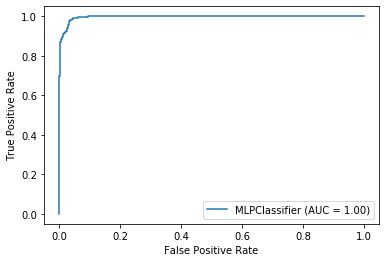

In [175]:
from sklearn.metrics import plot_roc_curve
roc_value = plot_roc_curve(nn_model, test_features, test_labels)
plt.show()

In [243]:
nn_explainer = explain(nn_model, data=test_features, y=test_labels, label='NeuralNetwork',
    predict_function=lambda X: nn_model.predict_proba(X)[::, 0])

In [244]:
for i in range(6):
    cp_plot(700+i, ['spore-print-color'], rf_explainer)
    cp_plot(700+i, ['spore-print-color'], nn_explainer)

## Task 6
> Comment on the results for points (4) and (5)

In [249]:
for letter in ['a','c','f','l','m','n','p','s','y']:
    print(letter, variable_encode(letter))

a 97
c 99
f 102
l 108
m 109
n 110
p 112
s 115
y 121


In [252]:
for letter in ['b','h','k','n','o','r','u','w','y']:
    print(letter, variable_encode(letter))

b 98
h 104
k 107
n 110
o 111
r 114
u 117
w 119
y 121
